In [2499]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import interp1d
from onix.analysis.probe import Probe
from onix.analysis.fitter import Fitter
from onix.data_tools import get_experiment_data, open_analysis_folder, get_analysis_file_path
from onix.helpers import data_identifier, console_bold, present_float

In [2500]:
name = "EO Spectroscopy"
analysis_number = None
identifier = None

def gaussian(f, f_0, a, sigma, c):
    numerator = (f - f_0) ** 2
    denominator = 2 * sigma ** 2
    return a * np.exp(-numerator / denominator) + c

def get_gaussian_fit(probe):
    signal = probe.averages("flop_no_bg")
    error = probe.errors("flop_no_bg")

    fitter = Fitter(gaussian)
    fitter.set_data(probe.probes, signal, error)
    fitter.set_p0({"f_0": 0})
    fitter.set_bounds("f_0", -0.5, 0.5)
    fitter.set_bounds("a", 0, np.inf)
    fitter.set_bounds("sigma", 0, 1)
    fitter.fit()
    return fitter

def get_interpolate_fit(probe):
    signal = probe.averages("flop_no_bg")
    error = probe.errors("flop_no_bg")
    fitter = Fitter(interpolated_fit)
    fitter.set_data(probe.probes, signal, error)
    fitter.fit()
    return fitter

def rabi_flopping(amplitude, amplitude_to_Omega, t, a):
    return a * np.sin(amplitude * amplitude_to_Omega * t / 2) ** 2

In [2501]:
def add_label(ax, x=0.02, y=1.1):
    ax.text(x, y, identifier, transform=ax.transAxes)

In [2502]:
def data_to_probe(data_number):
    data_index = data_numbers.index(data_number)
    data, headers = all_data[data_index]
    repeats = ["initial", "chasm", "antihole", "flop"]
    probe_repeats = headers["params"]["detect"]["repeats"]
    repeats = dict([(kk, probe_repeats) for kk in repeats])
    p = Probe(data["times"], data["transmissions"], repeats, data["monitors"])
    p.transmission_groups["flop_no_bg"] = p.transmission_groups["flop"] - p.transmission_groups["antihole"]
    p.monitor_groups["flop_no_bg"] = p.monitor_groups["flop"] - p.monitor_groups["antihole"]
    p.transmission_groups["antihole_no_bg"] = p.transmission_groups["antihole"] - p.transmission_groups["chasm"]
    p.monitor_groups["antihole_no_bg"] = p.monitor_groups["antihole"] - p.monitor_groups["chasm"]

    pre_probe_delay = headers["params"]["detect"]["ttl_detect_offset_time"].to("s").magnitude
    on_time = headers["params"]["detect"]["on_time"].to("s").magnitude
    off_time = headers["params"]["detect"]["off_time"].to("s").magnitude
    rise_delay = 2e-6
    fall_delay = 1e-6
    probe_detunings = headers["params"]["detect"]["detunings"].to("MHz").magnitude
    p.set_probe_times(pre_probe_delay, on_time, off_time, rise_delay, fall_delay, probe_detunings)
    return p

In [2011]:
#data_arxiv = {}

In [2047]:
#data_arxiv["20 ms probe"] = (scans_kHz, fit_amplitudes, fit_amplitude_errs)

In [2521]:
data_numbers = [1287]
all_data = [get_experiment_data(kk) for kk in data_numbers]
#flop_times_ms = [data[1]["params"]["flop"]["on_time"].to("ms").magnitude for data in all_data]
#offsets_kHz = [data[1]["params"]["flop"]["offset"].to("kHz").magnitude for data in all_data]
#amplitudes = [data[1]["params"]["flop"]["amplitude"] for data in all_data]
#scans_kHz = [data[1]["params"]["flop"]["scan"].to("kHz").magnitude for data in all_data]
probes = [data_to_probe(kk) for kk in data_numbers]
#fitters = [get_interpolate_fit(probe) for probe in probes]
#fit_amplitudes = [fitter.results["a"] for fitter in fitters]
#fit_amplitude_errs = [fitter.errors["a"] for fitter in fitters]

#identifier = "data " + data_identifier(data_numbers)

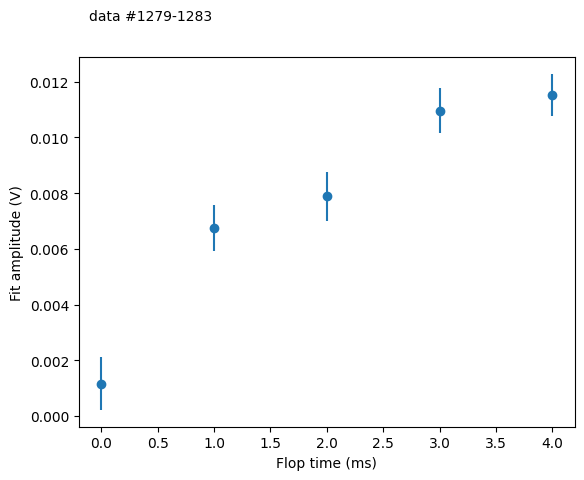

In [2522]:
fitter_flop = Fitter(rabi_flopping)
fitter_flop.set_data(flop_times_ms, fit_amplitudes, fit_amplitude_errs)
fitter_flop.set_p0({"amplitude_to_Omega": 0.2})
#fitter_flop.fit()

amplitudes_plt = np.linspace(min(flop_times_ms), max(flop_times_ms), 300)

fig, ax = plt.subplots()
add_label(ax)
ax.errorbar(flop_times_ms, fit_amplitudes, fit_amplitude_errs, fmt="o", ls="none")
#ax.plot(amplitudes_plt, fitter_flop.fitted_value(amplitudes_plt))
ax.set_xlabel("Flop time (ms)")
ax.set_ylabel("Fit amplitude (V)")
#ax.legend()
plt.show()

In [2523]:
index = -1
p = probes[index]
data_number = data_numbers[index]

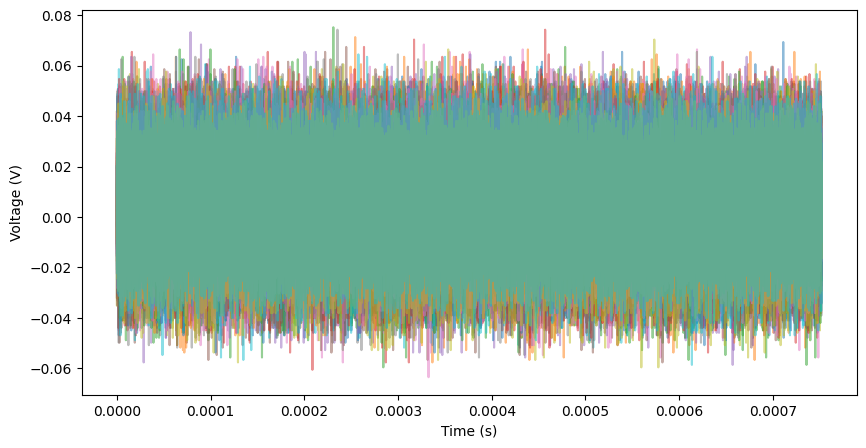

In [2528]:
fig, ax = plt.subplots(figsize=(10, 5))
group_name = "flop"
reshape_size = (
    p.transmission_groups[group_name].shape[0] * p.transmission_groups[group_name].shape[1],
    p.transmission_groups[group_name].shape[2]
)
ax.plot(p.times, p.transmission_groups[group_name].reshape(*reshape_size)[:].T, alpha=0.5)
#ax.set_xlim(0, 0.00001)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Voltage (V)")
plt.show()

No repeats found. Using the dataset standard error.
No repeats found. Using the dataset standard error.
No repeats found. Using the dataset standard error.
No repeats found. Using the dataset standard error.


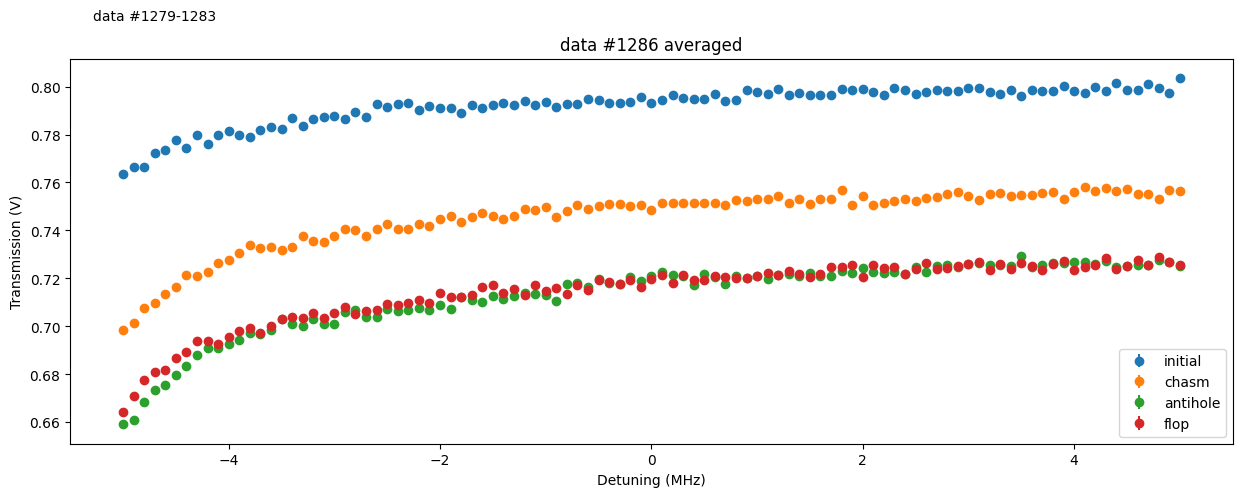

In [2519]:
fig, ax = plt.subplots(figsize=(15, 5))
add_label(ax)
ax.errorbar(p.probes, p.averages("initial"), p.errors("initial"), label="initial", ls="none", marker="o")
ax.errorbar(p.probes, p.averages("chasm"), p.errors("chasm"), label="chasm", ls="none", marker="o")
ax.errorbar(p.probes, p.averages("antihole"), p.errors("antihole"), label="antihole", ls="none", marker="o")
ax.errorbar(p.probes, p.averages("flop"), p.errors("flop"), label="flop", ls="none", marker="o")
ax.legend()
ax.set_xlabel("Detuning (MHz)")
ax.set_ylabel("Transmission (V)")
ax.set_title(f"data #{data_number} averaged")
plt.show()

No repeats found. Using the dataset standard error.
No repeats found. Using the dataset standard error.


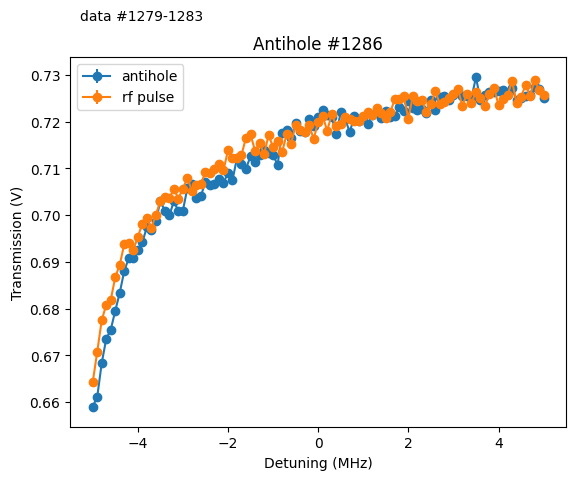

In [2520]:
fig, ax = plt.subplots()
add_label(ax)
zorder = 100
for kk in range(len(p.averages("antihole", mode="probe_repeats"))):
    signal = p.averages("antihole", mode="probe_repeats")[kk]
    error = p.errors("antihole", mode="probe_repeats")[kk]
    ax.errorbar(p.probes, signal, error, label=f"antihole", marker="o", zorder=zorder-kk)
    signal = p.averages("flop", mode="probe_repeats")[kk]
    error = p.errors("flop", mode="probe_repeats")[kk]
    ax.errorbar(p.probes, signal, error, label=f"rf pulse", marker="o", zorder=zorder-kk)
ax.legend()
ax.set_title(f"Antihole #{data_number}")
ax.set_xlabel("Detuning (MHz)")
ax.set_ylabel("Transmission (V)")
plt.show()

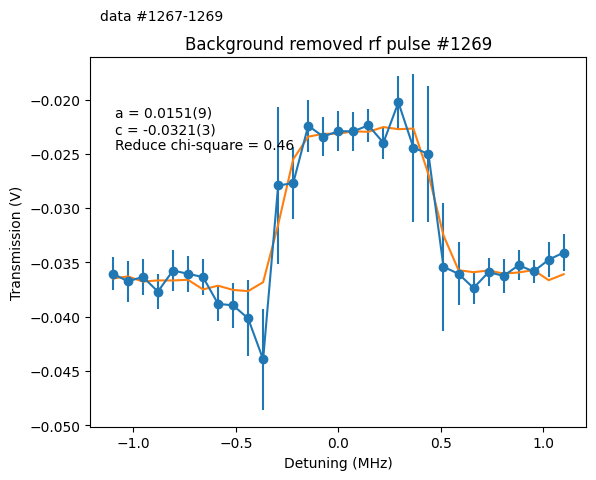

In [2474]:
fig, ax = plt.subplots()
add_label(ax)
zorder = 100
signal = p.averages("flop_no_bg")
error = p.errors("flop_no_bg")

# fitter = Fitter(gaussian)
# fitter.set_data(p.probes, signal, error)
# fitter.set_p0({"f_0": 0})
# fitter.set_bounds("f_0", -0.5, 0.5)
# fitter.set_bounds("a", 0, np.inf)
# fitter.set_bounds("sigma", 0, 1)
# fitter.fit()

fitter = Fitter(interpolated_fit)
fitter.set_data(p.probes, signal, error)
fitter.fit()

ax.errorbar(p.probes, signal, error, marker="o")
ax.plot(p.probes, fitter.fitted_value(p.probes))
ax.set_title(f"Background removed rf pulse #{data_number}")
ax.set_xlabel("Detuning (MHz)")
ax.set_ylabel("Transmission (V)")
ax.text(0.05, 0.75, fitter.all_results_str(), transform=ax.transAxes)
plt.show()

In [2394]:
#offsetted_signal = signal - np.average(signal)
#scaled_signal = offsetted_signal / (np.max(offsetted_signal) - np.min(offsetted_signal))
#fit_function = interp1d(p.probes, scaled_signal)
#def interpolated_fit(f, a, c):
#    return fit_function(f) * a + c

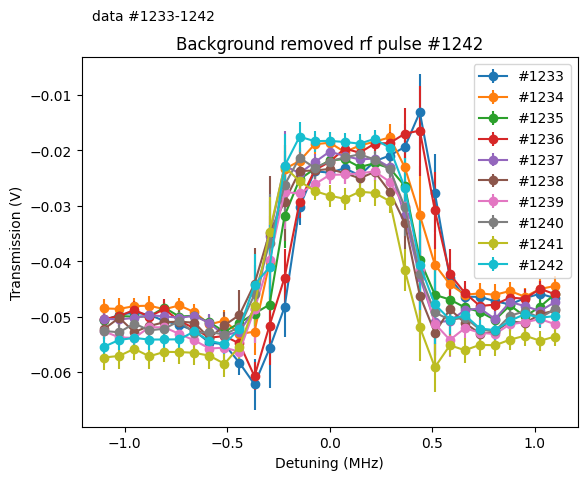

In [2395]:
fig, ax = plt.subplots()
add_label(ax)
zorder = 100
for kk, p in enumerate(probes):
    signal = p.averages("flop_no_bg")
    error = p.errors("flop_no_bg")

    ax.errorbar(p.probes, signal, error, marker="o", label=f'#{data_numbers[kk]}')
ax.set_title(f"Background removed rf pulse #{data_number}")
ax.set_xlabel("Detuning (MHz)")
ax.set_ylabel("Transmission (V)")
ax.legend()
plt.show()